In [1]:
from pyspark.mllib.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.tuning import (CrossValidator, ParamGridBuilder)

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import datetime

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import make_scorer
from math import sqrt

from collections import OrderedDict 

# IEOR 4571 - Personalization - Project 1
#### Team members: Megala Kannan, Hojin Lee, Jung Ah Shin, Tiffany Zhu

# TOC:
* [1. Introduction](#1)
* [2. Data Exploration](#2)
* [3. Modeling](#3)
    * [3.1 Baseline Model](#3-1)
    * [3.2 Neighborhood-Based Collaborative Filtering](#3-2)
        * [3.2.1 Tunning Hyperparameters](#3-2-1)
    * [3.3 Model-Based Collaborative Filtering](#3-3)
        * [3.3.1 Tunning Hyperparameters](#3-3-1)
        * [3.3.2 Accuracy of ALS Model](#3-3-2)
        * [3.3.3 Coverage of ALS Model](#3-3-3)
* [4. Evaluation](#4)
    * [4.1 Accuracy](#4-1)
        * [4.1.1 RMSE](#4-1-1)
        * [4.1.2 NDCG](#4-1-2)
    * [4.2 Coverage](#4-2)
    * [4.3 Changing Sample Size](#4-3)
* [5. Conclusion](#5)


# 1. Introduction <a class="anchor" id="1"></a>

# 2. Data Exploration <a class="anchor" id="2"></a>

Sampling: remove most popular movies and least popular movies.

# 3. Modeling <a class="anchor" id="3"></a>

## 3.1 Baseline Model <a class="anchor" id="3-1"></a>

In [2]:
ratings_df = pd.read_csv('ratings.csv')
percentages = [0.0001, 0.001, 0.01]

In [3]:
# Baseline model: Use the average rating of a movie in the training set as a predicted rating in the test set.
# If movie trying to predict in test set doesn't exist in training, give it 0 rating?

def baseline_predictor(avg_ratings, X):
    predictions = []
    rated_movies = avg_ratings['movieId'].values
    
    for index, row in X.iterrows():
        movieId = row['movieId']
        if movieId in rated_movies:
            predicted_rating = avg_ratings[avg_ratings['movieId'] == movieId]['rating']
            predictions.append(float(predicted_rating))
        else:
            # TODO: should actually just remove this data point?
            predictions.append(0)
    
    final_df = X.copy()
    final_df['rating'] = predictions
    return final_df

In [4]:
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

def get_ratings_for_each_user(df, rating_col_name='rating'):
    '''
    returns list of ratings for each user
    '''
    user_to_rating_dict = OrderedDict()
    relevent_per_user = []
    
    # predicted ratings per user
    for index, row in df.iterrows():
        userId = row['userId']
        rating = row[rating_col_name]
        if userId not in user_to_rating_dict:
            user_to_rating_dict[userId] = [rating]
        else:
            user_to_rating_dict[userId].append(rating)
            
    # create the relevent list
    for values in user_to_rating_dict.values():
        values = list(values)
        relevent_per_user.append(len(list(filter(lambda x: x>=3, values))))
    
    return list(user_to_rating_dict.values()), relevent_per_user

In [5]:
# Use baseline model to predict

baseline_rmses = []
baseline_rmses_train = []
baseline_ndcgs = []
baseline_ndcgs_train = []

for sample_percentage in percentages:
    ratings_sample_df = ratings_df.sample(frac=sample_percentage, random_state=1)

    X = ratings_sample_df.loc[:, ratings_sample_df.columns != 'rating']
    y = ratings_sample_df.loc[:, ratings_sample_df.columns == 'rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    training_sample = X_train.copy()
    training_sample['rating'] = y
    avg_ratings = training_sample.groupby('movieId', as_index = False).mean()
    
    # test predictions
    baseline_predicted_df = baseline_predictor(avg_ratings, X_test)
    # train predictions
    baseline_predicted_train_df = baseline_predictor(avg_ratings, X_train)
    
    # RMSE on test set
    y_actual = y_test['rating']
    y_predicted = baseline_predicted_df['rating']
    baseline_rmse = sqrt(mean_squared_error(y_actual.tolist(), y_predicted.tolist()))
    baseline_rmses.append(baseline_rmse)
    
    # RMSE on train set
    y_actual_train = y_train['rating']
    y_predicted_train = baseline_predicted_train_df['rating']
    baseline_rmse_train = sqrt(mean_squared_error(y_actual_train.tolist(), y_predicted_train.tolist()))
    baseline_rmses_train.append(baseline_rmse_train)
    
    # NDCG on test set
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(baseline_predicted_df)
    baseline_ndcg = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    baseline_ndcgs.append(baseline_ndcg)
    
    # NDCG on train set
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(baseline_predicted_train_df)
    baseline_ndcg_train = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    baseline_ndcgs_train.append(baseline_ndcg_train)

### RMSE of Baseline Model

In [6]:
baseline_rmses, baseline_rmses_train

([2.621317357265236, 1.5268019095541008, 1.0578281382515096],
 [0.5612772203248192, 0.8036162073990519, 0.9109795036364889])

### NDCG of Baseline Model

In [7]:
baseline_ndcgs, baseline_ndcgs_train

([0.558264306684059, 0.24578880515519028, 0.16365396179387082],
 [0.1871621108229913, 0.1594201877512688, 0.1486516548408536])

## 3.2 Neighborhood-Based Collaborative Filtering <a class="anchor" id="3-2"></a>

### 3.2.1 Tunning Hyperparameters <a class="anchor" id="3-2-1"></a>

## 3.3 Model-Based Collaborative Filtering: Matrix Factorization Using PySpark's Alternating Least Squares (ALS) <a class="anchor" id="3-3"></a>

We use the Alternating Least Square (ALS) model in PySpark with the same samples we used for the baseline model and the neighborhood-based model.

In [8]:
#Spark Session
spark =SparkSession.builder.appName('ALS').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Load ratings data into PySpark dataframe
data_schema = StructType([
    StructField('userId',IntegerType(), False),
    StructField('movieId',IntegerType(), False),
    StructField('rating',FloatType(), False)])

movie_ratings = spark.read.csv('ratings.csv', 
                               header=True, schema=data_schema).cache()

In [9]:
movie_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
|     1|     50|   3.5|
+------+-------+------+
only showing top 5 rows



## !!! SPARK DF from PANDA DF

In [10]:
# Create Spark DF from Pandas DF
X_train2 = X_train.iloc[:, X_train.columns != 'timestamp']
X_train2['rating'] = y_train
X_train_spark = spark.createDataFrame(X_train2, schema=data_schema)
X_train_spark.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
| 49103|   2476|   2.0|
|118265|   3760|   4.0|
| 99231|    481|   3.0|
|  7021|    208|   3.0|
| 76354|   2391|   3.0|
+------+-------+------+
only showing top 5 rows



# CONTINUING ON...

In [11]:
user_count = movie_ratings.select('userID').distinct().count()
movie_count = movie_ratings.select('movieID').distinct().count()
user_count, movie_count

(138493, 26744)

In [12]:
# ALS model without tunning parameters
als = ALS(maxIter=5, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

In [13]:
def sample_x_percent(sample_percentage):
    subset_ratings = movie_ratings.sample(False, sample_percentage, 42)
    (training, test) = subset_ratings.randomSplit([0.8, 0.2])
    return training, test

# training, test = sample_x_percent(sample_percentage)
# user_tr_sample_count = training.select('userID').distinct().count()
# movie_tr_sample_count = training.select('movieID').distinct().count()
# user_tr_sample_count, movie_tr_sample_count

### Different Sample Sizes

In [14]:
all_training_sets = []
all_test_sets = []
for percentage in percentages:
    trn, tst = sample_x_percent(sample_percentage)
    all_training_sets.append(trn)
    all_test_sets.append(tst)

training_1, training_2, training_3 = all_training_sets
test_1, test_2, test_3 = all_test_sets

### 3.3.1 Tunning Hyperparameters <a class="anchor" id="3-3-1"></a>

There are 3 hyperparameters to tune. First, we will tune `rank`, then `regParam`, and then `iter`. We use RSME to tune our parameters and cross validation with 3 folds. We do this on our traning set.

In [15]:
def tune_parameter(cv_func, paramGrid, percentages, all_training_sets):
    
    training_times = []
    cvModels = []
    results = []

    for i in range(len(percentages)):
        start_1 = datetime.datetime.now()
        cvModel = cv_func.fit(all_training_sets[i])
        end_1 = datetime.datetime.now()

        cvModels.append(cvModel)
        training_times.append(str(end_1 - start_1))
        results.append(list(zip(cvModel.avgMetrics, paramGrid)))

        print(str(end_1 - start_1))
    
    return training_times, cvModels, results
    

In [16]:
def plot_rmse_vs_param(cvModels, param_list, xlabel):
    plt.figure(figsize=(10, 6))
    for cvModel in cvModels: 
        plt.plot(param_list, cvModel.avgMetrics)

    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.title('RMSE vs {} by Sample Size'.format(xlabel))
    plt.legend(['{}% Sample'.format(p) for p in percentages])
    plt.grid(True)
    plt.show()

####  Tunning Rank

In [17]:
# tunning rank
rank_list = [5, 10, 20]
paramGrid = (ParamGridBuilder().addGrid(als.rank, rank_list).build())

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)

training_times, cvModels, results = tune_parameter(crossval, paramGrid, percentages, all_training_sets)

0:02:28.192795
0:02:16.764969
0:02:32.941755


It took similar times to tune the rank for each sample size.

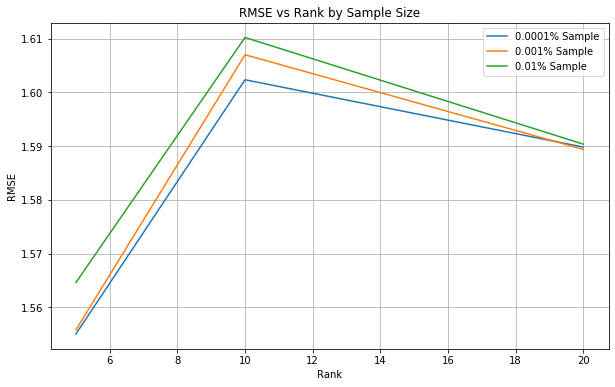

In [18]:
plot_rmse_vs_param(cvModels, rank_list, 'Rank')

In [19]:
best_rank=5

#### Tunning Regularization Parameter

In [20]:
reg_list = [0.001, 0.05, 0.1, 0.2]

# Use the best rank found above
als= ALS(maxIter=5, rank=best_rank, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

paramGrid_2 = ParamGridBuilder().addGrid(als.regParam, reg_list).build()

crossval_2 = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid_2,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)


training_times2, cvModels2, results2 = tune_parameter(crossval_2, paramGrid_2, percentages, all_training_sets)

0:02:56.114001
0:02:36.480402
0:02:43.287047


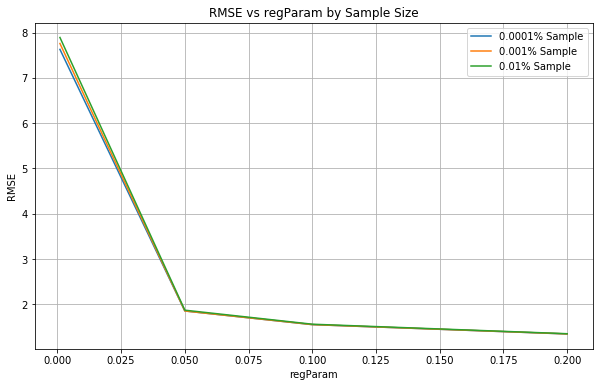

In [21]:
plot_rmse_vs_param(cvModels2, reg_list, 'regParam')

In [22]:
best_reg = 0.2

#### Tunning Number of Iterations -- DON'T THINK NEED TO TUNE?

In [23]:
iter_list = list(range(5,25,5))

# Use the best rank and best regParam found above
als= ALS(rank=best_rank, regParam=best_reg, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)
                 
paramGrid_3 = ParamGridBuilder().addGrid(als.maxIter, iter_list).build()

crossval_3 = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid_2,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)


training_times3, cvModels3, results3 = tune_parameter(crossval_3, paramGrid_3, percentages, all_training_sets)

0:03:03.231646
0:02:58.803813
0:03:16.252643


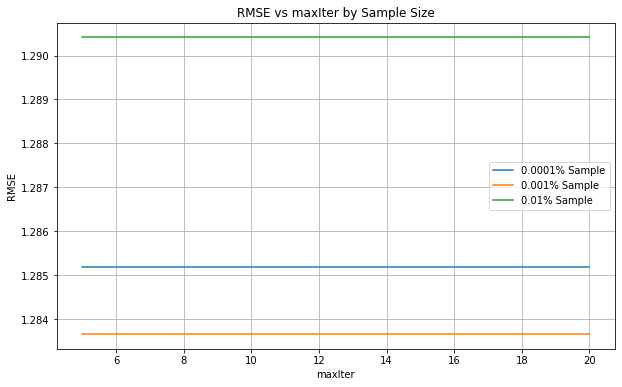

In [24]:
plot_rmse_vs_param(cvModels3, iter_list, 'maxIter')

In [25]:
best_iter = 10 # default

### 3.3.2 Accuracy of ALS Model <a class="anchor" id="3-3-2"></a>

### RSME 

training: with best rank, best reg, best iter

In [26]:
best_als_rmses_train = []
for cv in cvModels3:
    best_als_rmses_train.append(min(cv.avgMetrics))

best_als_rmses_train

[1.2851824836740715, 1.2836687867012728, 1.2904102158761792]

test: using the tunned params

In [28]:
best_als_models = []
best_predictions_test = []
best_predictions_train = []
best_als_rmses = []

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

for i in range(len(percentages)):
    best_als= ALS(rank=best_rank, regParam=best_reg, maxIter=best_iter, userCol="userId", 
                  itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative= True)

    best_als_model = als.fit(all_training_sets[i])
    als_predictions_test = best_als_model.transform(all_test_sets[i])
    als_predictions_train = best_als_model.transform(all_training_sets[i])
    rmse = evaluator.evaluate(als_predictions_test)
        
    best_als_models.append(best_als_model)
    best_predictions_test.append(als_predictions_test)
    best_predictions_train.append(als_predictions_train)
    best_als_rmses.append(rmse)

In [29]:
best_als_rmses

[1.1975945250181295, 1.215503317919368, 1.205372350935782]

### NDCG

In [30]:
best_predictions_test

[DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float]]

In [31]:
best_predictions_train

[DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float]]

In [32]:
# convert pyspark df to pandas df

als_predicted_test_dfs = []  # pandas DF
als_predicted_train_dfs = []  # pandas DF
als_test_ndcgs = []
als_train_ndcgs = []

for (best_prediction_test, best_prediction_train) in zip(best_predictions_test, best_predictions_train):
    # convert test predictions to pandas df
    als_predicted_test_df = best_prediction_test.toPandas()
    als_predicted_test_dfs.append(als_predicted_test_df)
    
    # convert train predictions to pandas df
    als_predicted_train_df = best_prediction_train.toPandas()
    als_predicted_train_dfs.append(als_predicted_train_df)
    
    # ndcg calculation for test predictions
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(als_predicted_test_df, rating_col_name='prediction')  
    als_ndcg = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    als_test_ndcgs.append(als_ndcg)
    
    # ndcg calculation for train predictions
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(als_predicted_train_df, rating_col_name='prediction')  
    als_ndcg_train = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    als_train_ndcgs.append(als_ndcg_train)


In [33]:
als_test_ndcgs, als_train_ndcgs

([0.4758525597655067, 0.4821906001221073, 0.48059521600326477],
 [0.3291251941876072, 0.3293691141956969, 0.33004223311159686])

### 3.3.3 Coverage of ALS Model <a class="anchor" id="3-3-3"></a>

In [35]:
k = 5

for i in range(len(best_predictions_test)):
    prediction = best_predictions_test[i]
    percentage = percentages[i]
    predictions_grouped_by_movieIds = prediction.groupby(['movieId'])
    pred_df = predictions_grouped_by_movieIds.agg(sql_func.count(col('userId')))
    pred_df2 = pred_df.filter(pred_df['count(userId)'] >= k)
    n_movie = pred_df2.count()

    potential_recommended_movies = all_test_sets[i].select("movieId").distinct()
    N_movie = potential_recommended_movies.count()

    print('Item Coverage ({0:.4}% sample): {1:.2}%'.format(percentage, (n_movie/N_movie) * 100))

Item Coverage (0.0001% sample): 2.8e+01%
Item Coverage (0.001% sample): 2.8e+01%
Item Coverage (0.01% sample): 2.8e+01%


In [36]:
k = 3
for i in range(len(best_predictions_test)):
    prediction = best_predictions_test[i]
    percentage = percentages[i]
    predictions_grouped_by_userIds = prediction.groupby(['userId'])
    pred_df = predictions_grouped_by_userIds.agg(sql_func.count(col('movieId')))
    pred_df2 = pred_df.filter(pred_df['count(movieId)'] >= k)
    n_user = pred_df2.count()

    potential_recommended_users = all_test_sets[i].select("userId").distinct()
    N_user = potential_recommended_users.count()

    print('User Coverage: ({0:.4}% sample): {1:.2}%'.format(percentage, (n_user/N_user) * 100))

User Coverage: (0.0001% sample): 8.4%
User Coverage: (0.001% sample): 8.2%
User Coverage: (0.01% sample): 8.2%


# 4. Evaluation <a class="anchor" id="4"></a>

## 4.1 Accuracy <a class="anchor" id="4-1"></a>

### 4.1.1 RMSE <a class="anchor" id="4-1-1"></a>

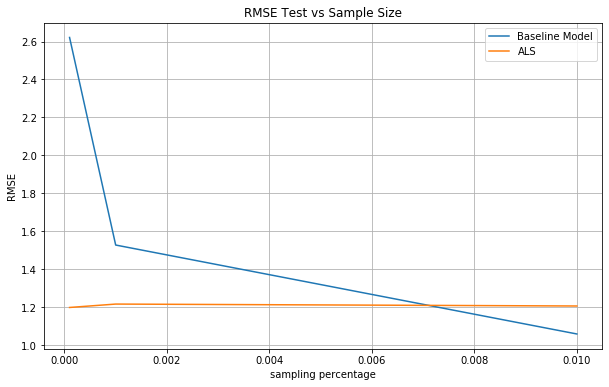

In [37]:
baseline_rmses, baseline_rmses_train
best_als_rmses, best_als_rmses_train

plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_rmses)
# add neighborhood based model
plt.plot(percentages, best_als_rmses)

plt.xlabel('sampling percentage')
plt.ylabel('RMSE')
plt.title('RMSE Test vs Sample Size')
plt.legend(['Baseline Model', 'ALS'])
plt.grid(True)
plt.show()

### 4.1.2 NDCG <a class="anchor" id="4-1-2"></a>

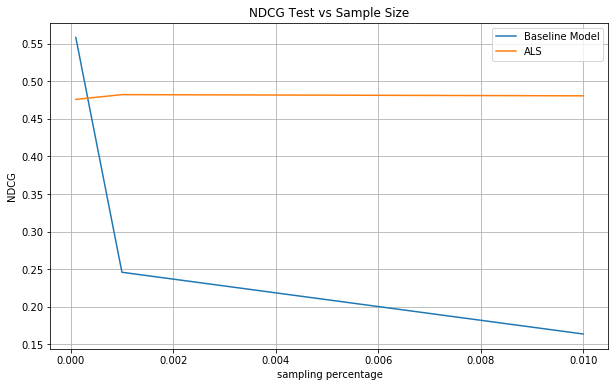

In [38]:
baseline_ndcgs, baseline_ndcgs_train
als_test_ndcgs, als_train_ndcgs

plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_ndcgs)
# add neighborhood based model
plt.plot(percentages, als_test_ndcgs)

plt.xlabel('sampling percentage')
plt.ylabel('NDCG')
plt.title('NDCG Test vs Sample Size')
plt.legend(['Baseline Model', 'ALS'])
plt.grid(True)
plt.show()

## 4.2 Coverage <a class="anchor" id="4-2"></a>

## 4.3 Changing Sample Size <a class="anchor" id="4-3"></a>

# 5. Conclusion <a class="anchor" id="5"></a>

In [ ]:
# # Generate top 10 movie recommendations for each user
# userRecs = model.recommendForAllUsers(10)
# # Generate top 10 user recommendations for each movie
# movieRecs = model.recommendForAllItems(10)